# Multiple Logistic Regression: From Scratch vs Library (Window Size = 14)

- Dataset: `CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv`
- Target: `Target_Return_7d` (binary)
- Features: selected from `CLASSIFY-AMZN_methods_all_in_one.csv`
- Models:
  1. Logistic Regression (from scratch via gradient descent)
  2. Logistic Regression (scikit-learn)

Outputs:
- Loss
- Confusion matrix
- Accuracy
- Precision, Sensitivity (Recall), Specificity (True Negative Rate), F1-score
- ROC & AUC
- Performance curves (loss and accuracy)

Missing features: ['vol_change']
Rows after cleaning: 4023
Number of features used: 6
Features used: ['lower_wick', 'upper_wick', 'ma_gap_20', 'co_ret', 'ret_1', 'range_pct']
=== Loss ===
Scratch log loss: 0.687241
Library log loss: 0.695674

=== Confusion Matrix ===
Scratch:
 [[ 53 277]
 [ 71 401]]
Library:
 [[ 70 260]
 [ 96 376]]

=== Metrics ===
Accuracy - Scratch: 0.5661 | Library: 0.5561
Precision - Scratch: 0.5914 | Library: 0.5912
Sensitivity (Recall) - Scratch: 0.8496 | Library: 0.7966
Specificity (TNR) - Scratch: 0.1606 | Library: 0.2121
F1-score - Scratch: 0.6974 | Library: 0.6787

=== ROC & AUC ===
Scratch AUC: 0.5000
Library AUC: 0.5007


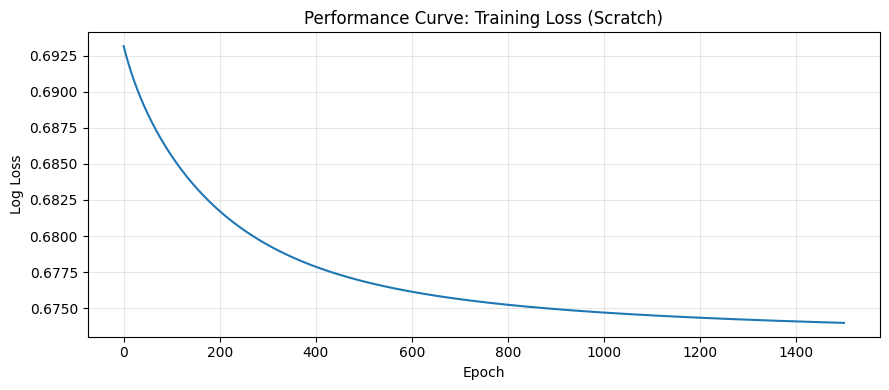

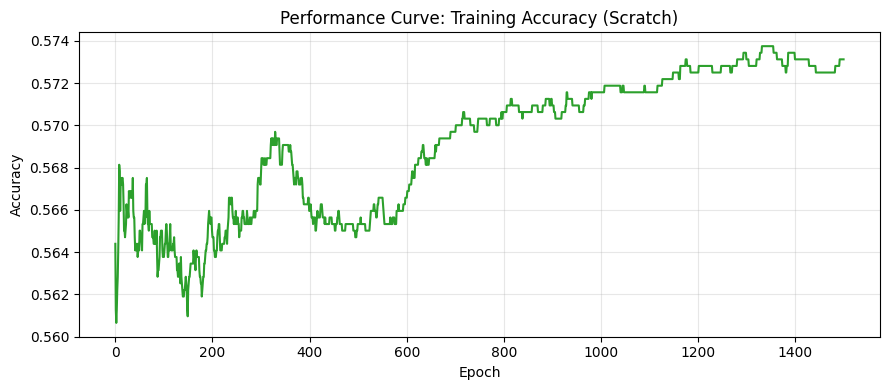

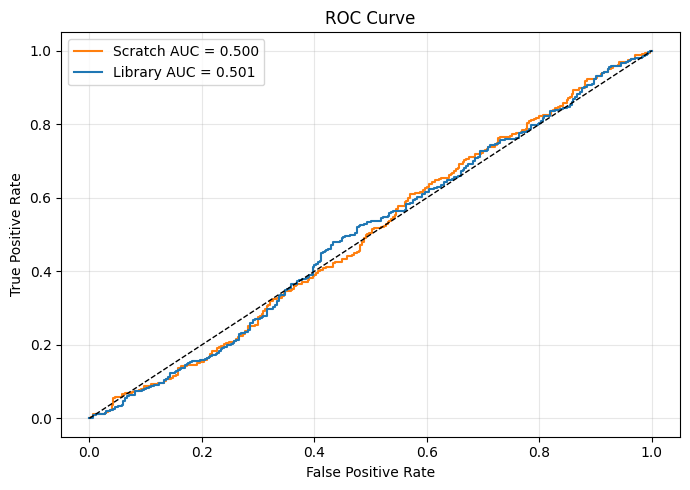

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'lower_wick',
    'upper_wick',
    'ma_gap_20',
    'co_ret',
    'ret_1',
    'range_pct',
    'vol_change'
]
allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns and c != TARGET_COL]
missing = [c for c in requested_features if c not in feature_cols]
if missing:
    print('Missing features:', missing)

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.float64)

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw = model_df[TARGET_COL].values.astype(np.float64)

# Ensure binary target
if not np.isin(np.unique(y_raw), [0, 1]).all():
    y_raw = (y_raw > 0).astype(np.float64)

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train = (X_train_raw - x_mean) / x_std
X_test = (X_test_raw - x_mean) / x_std

# ---------------------------------------------
# 3) Logistic Regression from scratch (GD)
# ---------------------------------------------
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=1500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0.0
        self.loss_history = []
        self.acc_history = []

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0
        eps = 1e-9

        for _ in range(self.epochs):
            logits = X @ self.w + self.b
            probs = self._sigmoid(logits)
            loss = -np.mean(y * np.log(probs + eps) + (1.0 - y) * np.log(1.0 - probs + eps))
            self.loss_history.append(loss)

            preds = (probs >= 0.5).astype(int)
            acc = np.mean(preds == y)
            self.acc_history.append(acc)

            error = probs - y
            dw = (1.0 / n_samples) * (X.T @ error)
            db = (1.0 / n_samples) * np.sum(error)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

scratch_model = LogisticRegressionScratch(lr=0.01, epochs=1500)
scratch_model.fit(X_train, y_train)
y_prob_scratch = scratch_model.predict_proba(X_test)
y_pred_scratch = scratch_model.predict(X_test)

# -------------------------------------
# 4) Logistic Regression library
# -------------------------------------
lib_model = LogisticRegression(max_iter=500)
lib_model.fit(X_train, y_train)
y_prob_lib = lib_model.predict_proba(X_test)[:, 1]
y_pred_lib = (y_prob_lib >= 0.5).astype(int)

# ------------------------
# 5) Metrics and outputs
# ------------------------
loss_scratch = log_loss(y_test, y_prob_scratch)
loss_lib = log_loss(y_test, y_prob_lib)

cm_scratch = confusion_matrix(y_test, y_pred_scratch)
cm_lib = confusion_matrix(y_test, y_pred_lib)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
acc_lib = accuracy_score(y_test, y_pred_lib)

precision_scratch = precision_score(y_test, y_pred_scratch, zero_division=0)
precision_lib = precision_score(y_test, y_pred_lib, zero_division=0)

recall_scratch = recall_score(y_test, y_pred_scratch, zero_division=0)
recall_lib = recall_score(y_test, y_pred_lib, zero_division=0)

f1_scratch = f1_score(y_test, y_pred_scratch, zero_division=0)
f1_lib = f1_score(y_test, y_pred_lib, zero_division=0)

tn_s, fp_s, fn_s, tp_s = cm_scratch.ravel()
tn_l, fp_l, fn_l, tp_l = cm_lib.ravel()

specificity_scratch = tn_s / (tn_s + fp_s) if (tn_s + fp_s) > 0 else 0.0
specificity_lib = tn_l / (tn_l + fp_l) if (tn_l + fp_l) > 0 else 0.0

print('=== Loss ===')
print(f'Scratch log loss: {loss_scratch:.6f}')
print(f'Library log loss: {loss_lib:.6f}')

print('\n=== Confusion Matrix ===')
print('Scratch:\n', cm_scratch)
print('Library:\n', cm_lib)

print('\n=== Metrics ===')
print(f'Accuracy - Scratch: {acc_scratch:.4f} | Library: {acc_lib:.4f}')
print(f'Precision - Scratch: {precision_scratch:.4f} | Library: {precision_lib:.4f}')
print(f'Sensitivity (Recall) - Scratch: {recall_scratch:.4f} | Library: {recall_lib:.4f}')
print(f'Specificity (TNR) - Scratch: {specificity_scratch:.4f} | Library: {specificity_lib:.4f}')
print(f'F1-score - Scratch: {f1_scratch:.4f} | Library: {f1_lib:.4f}')

# ROC & AUC
fpr_s, tpr_s, _ = roc_curve(y_test, y_prob_scratch)
fpr_l, tpr_l, _ = roc_curve(y_test, y_prob_lib)
roc_auc_s = roc_auc_score(y_test, y_prob_scratch)
roc_auc_l = roc_auc_score(y_test, y_prob_lib)

print('\n=== ROC & AUC ===')
print(f'Scratch AUC: {roc_auc_s:.4f}')
print(f'Library AUC: {roc_auc_l:.4f}')

# ---------------------------------------------------------
# 6) Performance curves (loss + accuracy) and ROC
# ---------------------------------------------------------
# Performance curve: Loss (scratch)
plt.figure(figsize=(9, 4))
plt.plot(scratch_model.loss_history, color='tab:blue')
plt.title('Performance Curve: Training Loss (Scratch)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Performance curve: Accuracy (scratch)
plt.figure(figsize=(9, 4))
plt.plot(scratch_model.acc_history, color='tab:green')
plt.title('Performance Curve: Training Accuracy (Scratch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr_s, tpr_s, label=f'Scratch AUC = {roc_auc_s:.3f}', color='tab:orange')
plt.plot(fpr_l, tpr_l, label=f'Library AUC = {roc_auc_l:.3f}', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()